https://www.matichon.co.th/politics/news_1834104

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
src = cv.imread('ballot-1.jpeg')

In [3]:
p = 0
dst_points = np.array([[200, 320],
                       [890, 320],
                       [190, 720],
                       [890, 720]
                  ]).astype(np.float32)
w,h = src.shape[:2]
src_points = np.array([[p, p],
                   [h - p, p],
                   [p, w - p],
                   [h - p, w - p]
                  ]).astype(np.float32)


In [4]:
src_points

array([[   0.,    0.],
       [1068.,    0.],
       [   0.,  797.],
       [1068.,  797.]], dtype=float32)

In [5]:
w,h = dst_points.max(0).astype(int)
w,h

(890, 720)

In [6]:
box_dst = src.copy()
for dot in dst_points.astype(int):
    box_dst = cv.circle(box_dst, dot, 10, (0,0,255), -1)

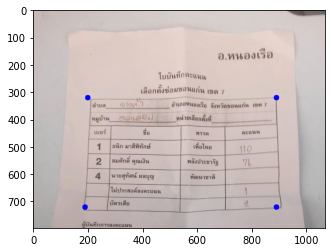

In [7]:
plt.imshow(box_dst)

In [8]:
warp_mat = cv.getPerspectiveTransform(dst_points, src_points)

In [9]:
warp_dst = cv.warpPerspective(src, warp_mat, (src.shape[1], src.shape[0]))

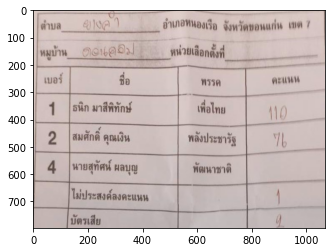

In [10]:
plt.imshow(warp_dst)

In [11]:
import easyocr

In [12]:
# reader = easyocr.Reader(['th'],)

In [13]:
# horizontal_list, free_list = reader.detect(warp_dst)

In [14]:
# text_rect_img = warp_dst.copy()
# for rect in horizontal_list[0]:
#     x,y,h,w = rect
#     text_rect_img = cv.rectangle(text_rect_img, (x,h), (y,w), 1, 2)
# plt.imshow(text_rect_img)

# Recreate vote count paper

In [15]:
from PIL import Image, ImageFont, ImageDraw

In [19]:
font = ImageFont.truetype('formal/THsarabun.ttf',size=30)

In [20]:
def put_text_center(message, y):
    left, top, right, bottom = draw.textbbox((0, 0), message, font=font)
    draw.text(((image_width-right)/2, y), message, 0, align='center', font=font)
    return left, top, right, bottom

In [21]:
def width_of_text(message):
    left, top, right, bottom = draw.textbbox((0, 0), message, font=font)
    return right - left

In [22]:
table = """ตำบล           อำเภออิิอิ จังหวัดหึหึ เขต 99 สาธุ
หมู่บ้าน          เขตเลือกตั้งที่
เบอร์|ชื่อ|พรรค|คะแนน
1|ปิดทอง หลังพระ|คนดี|992
4|ชื่อคนที่ 2|ส้ม|12
2|ชื่อคนที่ 2|แดง|42
2|ชื่อคนที่ 2|แดง|42
2|ชื่อคนที่ 2|แดง|42
2|ชื่อคนที่ 2|แดง|42
|ไม่ประสงค์ลงคะแนน||3
|บัตรเสีย||"""
tables = [l.split('|')for l in table.split('\n')]

In [23]:
image_width = 826
image_height = 1169
image = Image.new('RGB', (image_width, image_height,), '#fff')
draw = ImageDraw.Draw(image, )

In [24]:
cell_width = np.array([[width_of_text(y)+10 for y in x] for x in tables[2:]])
rat = cell_width.max(0)/cell_width.max(0).sum()
rat

array([0.14447592, 0.50141643, 0.15580737, 0.19830028])

In [26]:
draw.text((image_width-150, 100), "อ.อ่าง", 0, align='left', font=font)
put_text_center("ใบบันทึกคะแนน", 200)
put_text_center("เลือกตั้งซ่อมขอนไม่แก่น เขต 90", 240)

(0, 1, 252, 26)

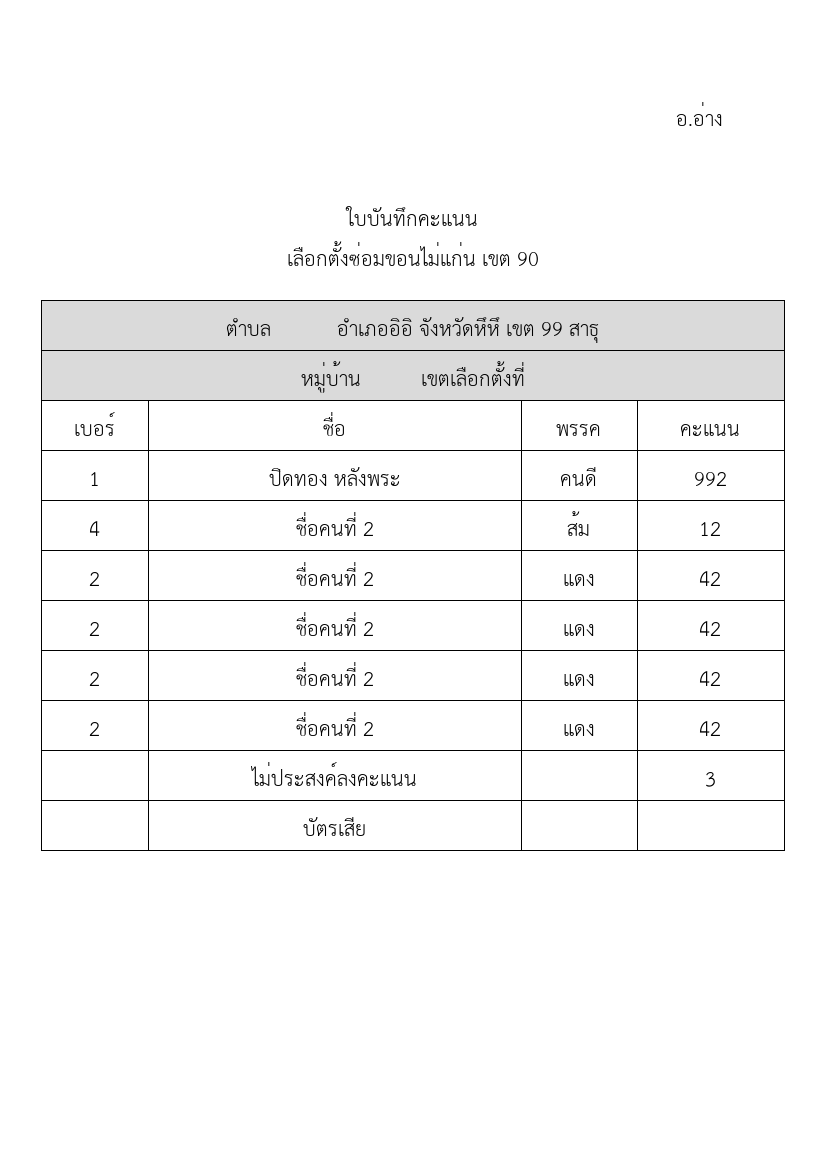

In [27]:
start_y = 300
points = []
table_width = image_width * 0.9
for i,row_text in enumerate(tables):
    row_start = (image_width-table_width)/2
    cols_ratio = [1] if len(row_text) < 2 else rat
    for wr, text in zip(cols_ratio, row_text):
        cell_width = table_width*wr
        draw.rectangle(
            (row_start,
             start_y,
             row_start+cell_width,
             start_y+50,),
            '#dadada' if i < 2 else None,
            0
        )
        points.append((row_start, start_y, row_start+cell_width, start_y+50,))
        cell_center = row_start + cell_width/2
        message = text

        left, top, right, bottom = draw.textbbox((0, 0), message, font=font)
        draw.text((cell_center-right/2, start_y+10), message, 0, align='center', font=font)

        row_start = row_start + cell_width
    start_y += 50
image

In [28]:
table_bbox = (min([xyxy[0] for xyxy in points]),
              min([xyxy[1] for xyxy in points]),
              max([xyxy[2] for xyxy in points]),
              max([xyxy[3] for xyxy in points]))

# Augment

In [29]:
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa

In [30]:
seq = iaa.Sequential([
    iaa.Crop(px=(0, 10)),
    iaa.ElasticTransformation(alpha=200, sigma=60),
    iaa.pillike.EnhanceBrightness(factor=(0.6,1.4)),
    iaa.CoarseDropout(0.0005, size_percent=0.4),
    iaa.AllChannelsCLAHE(clip_limit=(1, 10)),
    iaa.GaussianBlur(sigma=(0, 1.2)),
    iaa.pillike.FilterSharpen(),
iaa.PerspectiveTransform(scale=(0.01, 0.05)),
    iaa.Affine(scale=(0.5, 1.5))
])

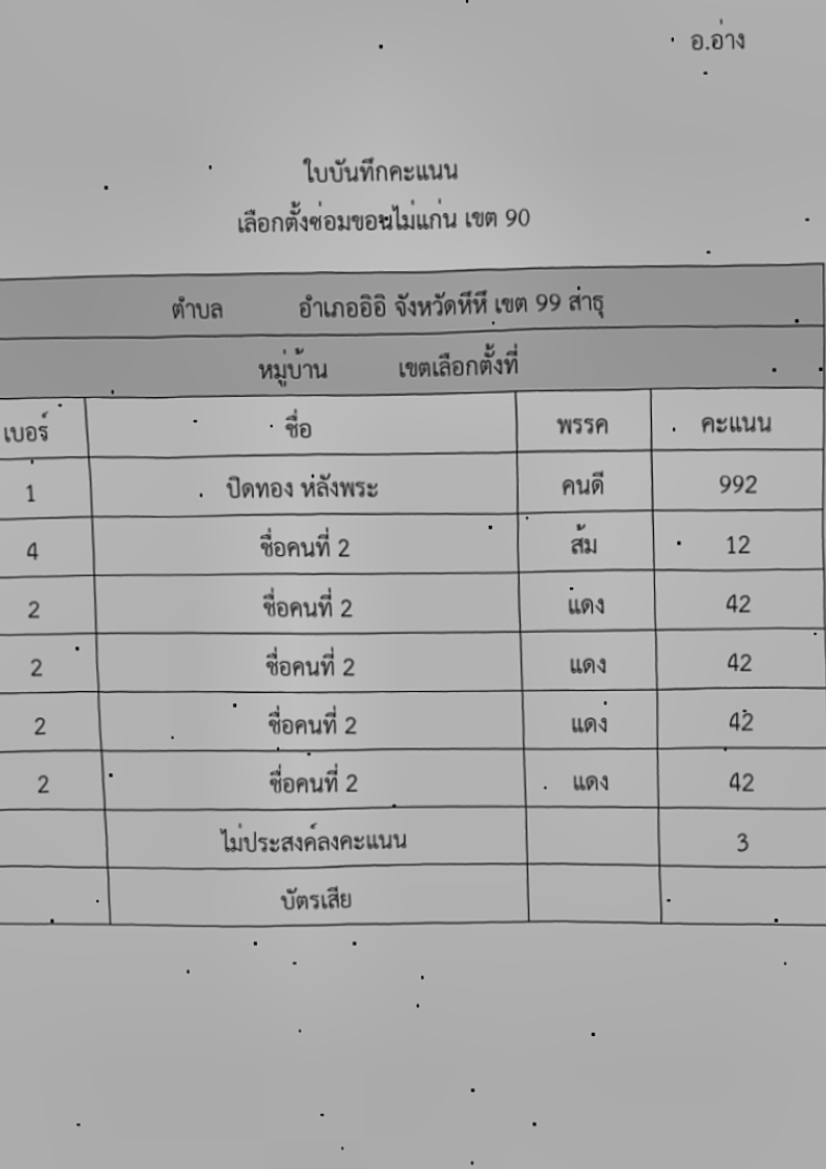

In [31]:
np_image = np.array(image)
bbs = BoundingBoxesOnImage([
    BoundingBox(*table_bbox,),
    BoundingBox(0,0,*image.size)
], shape=np_image.shape)
aug_images, aug_bboxes = seq(images=[np_image],bounding_boxes=[bbs])
Image.fromarray(aug_images[0])

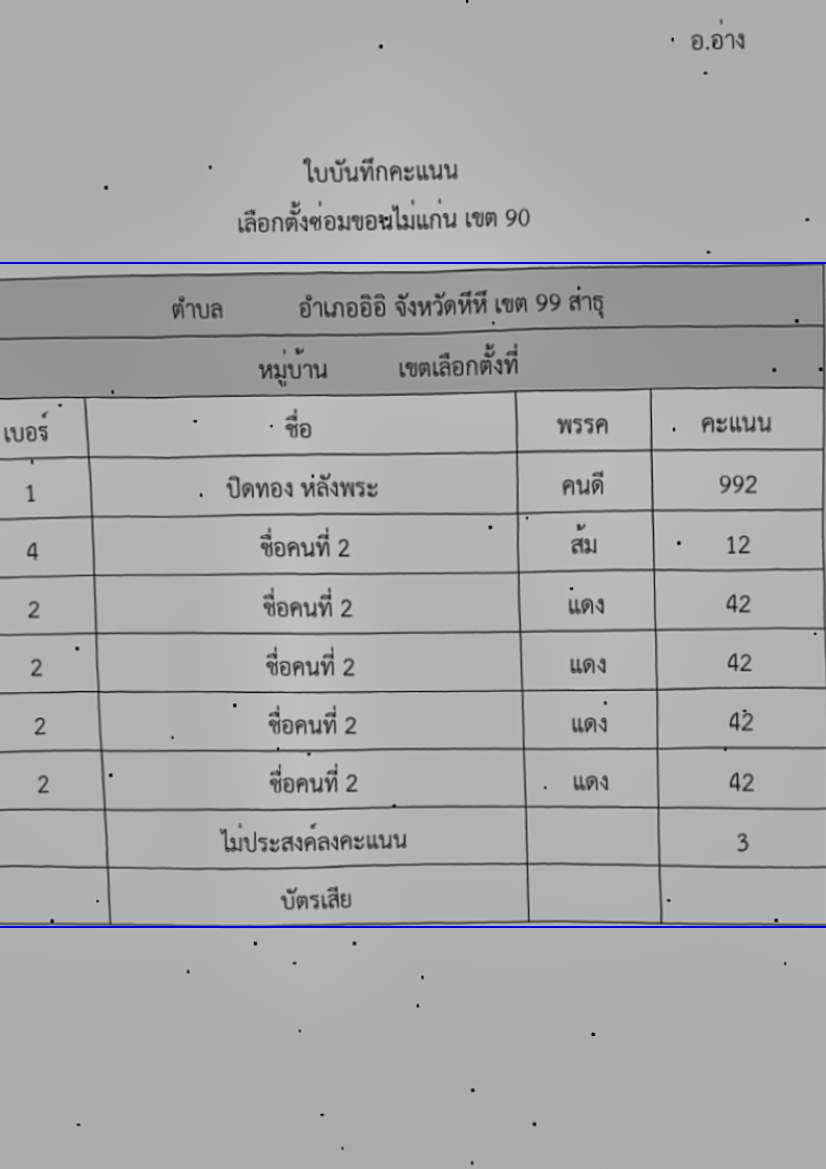

In [32]:
Image.fromarray(aug_bboxes[0].draw_on_image(aug_images[0], size=2, color=[0, 0, 255]))

# Creat template

In [33]:
import re
import pandas as pd
import random

In [34]:
# https://suilad.wordpress.com/2012/05/09/code-python-%E0%B9%81%E0%B8%9B%E0%B8%A5%E0%B8%87%E0%B8%95%E0%B8%B1%E0%B8%A7%E0%B9%80%E0%B8%A5%E0%B8%82-%E0%B9%84%E0%B8%9B%E0%B9%80%E0%B8%9B%E0%B9%87%E0%B8%99-%E0%B8%95%E0%B8%B1%E0%B8%A7%E0%B8%AB/
thai_number = ("ศูนย์", "หนึ่ง", "สอง", "สาม", "สี่", "ห้า", "หก", "เจ็ด", "แปด", "เก้า")
unit = ("", "สิบ", "ร้อย", "พัน", "หมื่น", "แสน", "ล้าน")

def unit_process(val):
    length = len(val) > 1
    result = ''

    for index, current in enumerate(map(int, val)):
        if current:
            if index:
                result = unit[index] + result

            if length and current == 1 and index == 0:
                result += 'เอ็ด'
            elif index == 1 and current == 2:
                result = 'ยี่' + result
            elif index != 1 or current != 1:
                result = thai_number[current] + result

    return result

def thai_num2text(number):
    s_number = str(number)[::-1]
    n_list = [s_number[i:i + 6].rstrip("0") for i in range(0, len(s_number), 6)]
    result = unit_process(n_list.pop(0))

    for i in n_list:
        result = unit_process(i) + 'ล้าน' + result

    return result

In [35]:
last_names_th = open('family_names_th.txt').read().split('\n')[:-1]
names_th = open('female_names_th.txt').read().split('\n')[:-1]

In [36]:
geo_names = pd.read_csv('tambons.csv')
geo_names.sample()

,AD_LEVEL,TA_ID,TAMBON_T,TAMBON_E,AM_ID,AMPHOE_T,AMPHOE_E,CH_ID,CHANGWAT_T,CHANGWAT_E,LAT,LONG
4866,4,540502,ต. แม่จั๊วะ,Mae Chua,5405,อ. เด่นชัย,Den Chai,54,จ. แพร่,Phrae,17.975,100.104


In [37]:
political_parties_th = ['พรรคประชาธิปัตย์', 'พรรคประชากรไทย', 'พรรคความหวังใหม่', 'พรรคเครือข่ายชาวนาแห่งประเทศไทย',
                        'พรรคเพื่อไทย', 'พรรคเพื่อแผ่นดิน', 'พรรคชาติพัฒนา', 'พรรคชาติไทยพัฒนา', 'พรรคอนาคตไทย', 
                        'พรรคภูมิใจไทย', 'พรรคสังคมประชาธิปไตยไทย', 'พรรคประชาสามัคคี', 'พรรคประชาธิปไตยใหม่', 
                        'พรรคพลังชล', 'พรรคครูไทยเพื่อประชาชน', 'พรรคพลังสหกรณ์', 'พรรคพลังท้องถิ่นไท', 
                        'พรรคถิ่นกาขาวชาววิไล', 'พรรครักษ์ผืนป่าประเทศไทย', 'พรรคไทรักธรรม', 'พรรคเสรีรวมไทย', 
                        'พรรครักษ์ธรรม', 'พรรคเพื่อชาติ', 'พรรคพลังประชาธิปไตย', 'พรรคภราดรภาพ', 
                        'พรรคพลังไทยรักชาติ', 'พรรคเพื่อชีวิตใหม่', 'พรรคก้าวไกล', 'พรรคทางเลือกใหม่', 
                        'พรรคประชาภิวัฒน์', 'พรรคพลเมืองไทย', 'พรรคพลังไทยนำไทย', 'พรรคพลังธรรมใหม่', 'พรรคไทยธรรม', 
                        'พรรคไทยศรีวิไลย์', 'พรรครวมพลังประชาชาติไทย', 'พรรคสยามพัฒนา', 'พรรคเพื่อคนไทย', 'พรรคพลังปวงชนไทย', 
                        'พรรคพลังไทยรักไทย']
political_parties_th = [p[4:] for p in  political_parties_th]

In [38]:
months_th = 'มกราคม กุมภาพันธ์ มีนาคม เมษายน พฤษภาคม มิถุนายน กรกฎาคม สิงหาคม กันยายน ตุลาคม พฤศจิกายน ธันวาคม'.split()

In [605]:
text_template = """\t\t\t\t\tรายงานผลการนับคะแนนสมาชิกสภาผู้แทนราษฎรแบบแบ่งเขตเลือกตั้ง
\t\t\t\t\t\t\t\t\t-----------------------------------
\tตามที่ได้มีพระราชกฤษฎีกาให้มีการเลือกตั้งสมาชิกสภาผู้แทนราษฎรและคณะกรรมการการเลือกตั้งได้กำหนดให้วันที่ {date_th} เดือน {month_th} พ.ศ. {year_th} เป็นวันเลือกตั้ง
\tบัดนี้ คณะกรรมการประจำหน่วยเลือกตั้งใด้ดำเนินการนับคะแบนสมาชิกสภาผู้แทนราษฎรแบบแบ่งเขตเลือกตั้งของหน่วยเลือกตั้งที่ {number_handwriting} หมู่ที่ {number_handwriting} ตำบล/เทศบาล {tambon_name_handwriting_th} อำเภอ {amphoe_handwriting_th} เขตเลือกตั้งที่ {number_th} จังหวัด {province_th} เสร็จสิ้นเป็นที่เรียบร้อยแล้ว ดังนั้น จึงขอรายงานผลการนับคะแนนของหน่วยเลือกตั้งดังกล่าว ดังนี้
\t๑. จำนวนผู้มีสิทธิเลือกตั้ง
\t\t๑.๑ จำนวนผู้มีสิทธิเลือกตั้งตามบัญชีรายชื่อผู้มิสิทธิเลือกตั้ง {number_handwriting} คน
({number_reading_handwriting_th})
\t\t๑.๒ จำนวนผู้มีสิทธิเลือกตั้งที่มาแสดงตน {number_handwriting} คน ({number_reading_handwriting_th}) (เฉพาะวันเลือกตั้ง)
\t๒. จำนวนบัตรเลือกตั้ง
\t\t๒.๑ จำนวนบัตรเลือกตั้งที่ได้รับจัดสรร {number_handwriting} บัตร ({number_reading_handwriting_th})
\t\t๒.๒ จำนวนบัตรเลือกตั้งที่ใช้ {number_handwriting} บัตร ({number_reading_handwriting_th})
\t\t\t๒.๒.๑ บัตรดี {number_handwriting} บัตร ({number_reading_handwriting_th})
\t\t\t๒.๒.๒ บัตรเสีย {number_handwriting} บัตร ({number_reading_handwriting_th})
\t\t\t๒.๒.๓ บัตรไม่เลือกผู้สมัครใด {number_handwriting} บัตร ({number_reading_handwriting_th})
\t\t๒.๓ จำนวนบัตรเลือกตั้งที่เหลือ {number_handwriting} บัตร ({number_reading_handwriting_th})
\t๓. จำนวนคะแนนที่ผู้สมัครรับเลือกตั้งแต่ละคนได้รับเรียงตามลำดับหมายเลขประจำตัวผู้สมัคร
%%table
หมายเลข<sep>ประจำตัวผู้สมัคร|ชื่อ-สกุล<sep>ผู้สมัครรับเลือกตั้ง|สังกัด<sep>พรรคการเมือง|ได้คะแนน<sep>(ให้กรอกทั้งตัวเลขและตัวอักษร)
{number_th}|{title_th}{name_th} {lastname_th}|{party_name_th}|{number_handwriting} ({number_reading_number_handwriting_th})
{number_th}|{title_th}{name_th} {lastname_th}|{party_name_th}|{number_handwriting} ({number_reading_number_handwriting_th})
{number_th}|{title_th}{name_th} {lastname_th}|{party_name_th}|{number_handwriting} ({number_reading_number_handwriting_th})
{number_th}|{title_th}{name_th} {lastname_th}|{party_name_th}|{number_handwriting} ({number_reading_number_handwriting_th})
%%table
ชุดที่ ๒ ปิดประกาศ ณ ที่เลือกตั้ง
"""

In [606]:
font = ImageFont.truetype('formal/THSarabun.ttf',size=24)

In [607]:
image_width = 826
image_height = 1169
image = Image.new('RGB', (image_width, image_height,), '#fff')
draw = ImageDraw.Draw(image,)

In [608]:
text = []
text_box = image_width - 100 * 2
text_sample = text_template.replace('\t', ' '*8)
for line in text_sample.split('\n'):
    count = 0
    line_new = ''
    
    for c in line:
        if c not in ['ั', 'า', 'ำ', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', '็', '่', '้']:
            if count + font.getlength(c) > text_box:
                count = 0
                text.append(line_new)
                line_new = ''
            count += font.getlength(c)
        line_new += c
    text.append(line_new)

In [609]:
big_pieces = re.split('(\<[^\>]*\>|\t|\n| |\{[^\}]*\}|%%\w+)', text_template)
import attacut
tokens = []

for piece in big_pieces:
    if re.findall('[\u0E00-\u0E0F]+',piece):
        tokens.extend(attacut.tokenize(piece))
    elif piece == '':
        continue
    else:
        tokens.append(piece)

In [610]:
def arabic2th(n):
    return chr(ord(n)+(ord('๑')-ord('1')))

In [611]:
import os

class RandomFont:
    def __init__(self, font_dir: str):
        self.font_paths = [os.path.join(font_dir, fp)for fp in os.listdir(font_dir) if fp.endswith('.ttf')]

    def get(self, size=24):
        return ImageFont.truetype(random.choice(self.font_paths), size=size)

In [612]:
fonts = {'sarabun':RandomFont('formal'),
         'handwriting': RandomFont('handwriting')
        }

In [613]:
fonts['handwriting'].get()

In [614]:
class BBox:
    def __init__(self, x0=None, y0=None, x1=None, y1=None):
        self.x0 = x0
        self.x1 = y0
        self.y0 = x1
        self.y1 = y1
        pass
    def merge(self,x0,y0,x1,y1):
        if self.x0 is None:
            self.x0 = x0
            self.x1 = x1
            self.y0 = y0
            self.y1 = y1
        else:
            self.x0 = min(self.x0,x0)
            self.y0 = min(self.y0,y0)
            self.x1 = max(self.x1,x1)
            self.y1 = max(self.y1,y1)

    def to_list(self,):
        return [self.x0, self.y0, self.x1, self.y1]

    def __repr__(self,):
        return f'({self.x0},{self.y0},{self.x1},{self.y1})'
            

In [655]:
class TextToken:
    def __init__(self, token: str, align='left', font_type='sarabun'):
        self.token = token
        self.is_special = True if re.match('\{[^\}]*\}', token) else False
        self.font_type = font_type
        if self.is_special and 'handwriting' in token:
            self.font_type = 'handwriting'
        self.align = align
    
    def put_on(self, x, y, min_x, max_x, line_height, image: ImageDraw, color='#000'):
        text, secondary_text = self._get_text()
        
        x0,y0,x1,y1 = image.textbbox((x, y), text, font=fonts['sarabun'].get())
        if text == '\n':
            return min_x, y + line_hieght
        if text == '\t':
            return x + 30, y
        if x1 > max_x:
            x = min_x
            y += line_height
            
        
        if secondary_text is not None:
            font=fonts['sarabun'].get()
            
            x0,y0,x1,y1 = image.textbbox((x, y), text, font=font)
            image.text((x, y), text, color, font=font)

            font=fonts['handwriting'].get(random.randint(24,32))
            underline_width = font.getlength(secondary_text)

            xy_pos = (random.randint(int(x0), int(max(x0, int(x1-underline_width-10)))), random.randint(y-5, y+2))
            
            font=fonts['handwriting'].get()
            xyxy = image.textbbox(xy_pos, secondary_text, font=font)
            image.text(xy_pos, secondary_text, pen_color, font=font)
        else:
            x0,y0,x1,y1 = image.textbbox((x, y), text, font=fonts['sarabun'].get())
            image.text((x,y), text, color, font=fonts[self.font_type].get())

        return x1, y

    def __repr__(self, ):
        return self.token
    
    def _get_text(self):
        if not self.is_special:
            return self.token, None

        dot_count = 30
        if 'tambon' in self.token:
            token = tambon.TAMBON_T.item().replace('ต.','')
        elif 'amphoe' in self.token:
            token = tambon.AMPHOE_T.item().replace('อ.','')
        elif 'province' in self.token:
            token = tambon.CHANGWAT_T.item().replace('จ.','')
        elif 'lastname' in self.token:
            token = random.choice(last_names_th)
        elif 'party_name' in self.token:
            token = random.choice(political_parties_th)
        elif 'name' in self.token:
            token = random.choice(names_th)
        elif 'title' in self.token:
            token = random.choice(['นาย','นางสาว','นาง'])
        elif 'number' in self.token:
            number = random.randint(1,100)
            dot_count = 10
            if 'reading' in self.token:
                number = thai_num2text(number)
                dot_count = 40
            elif 'th' in self.token:
                number = str(number)
                number = ''.join([arabic2th(n) for n in number])
            else:
                number = str(number)
            token = number
        elif 'date' in self.token:
            number = str(random.randint(1,31))
            if 'th' in self.token:
                number = ''.join([arabic2th(n) for n in number])
            token = number
        elif 'year' in self.token:
            number = str(random.randint(2500,2570))
            if 'th' in self.token:
                number = ''.join([arabic2th(n) for n in number])
            token = number
        elif 'month' in self.token:
            token = random.choice(months_th)
        secondary_text = None
        if self.font_type == 'handwriting':
            secondary_text = token
            token = '.' * dot_count
        return token, secondary_text

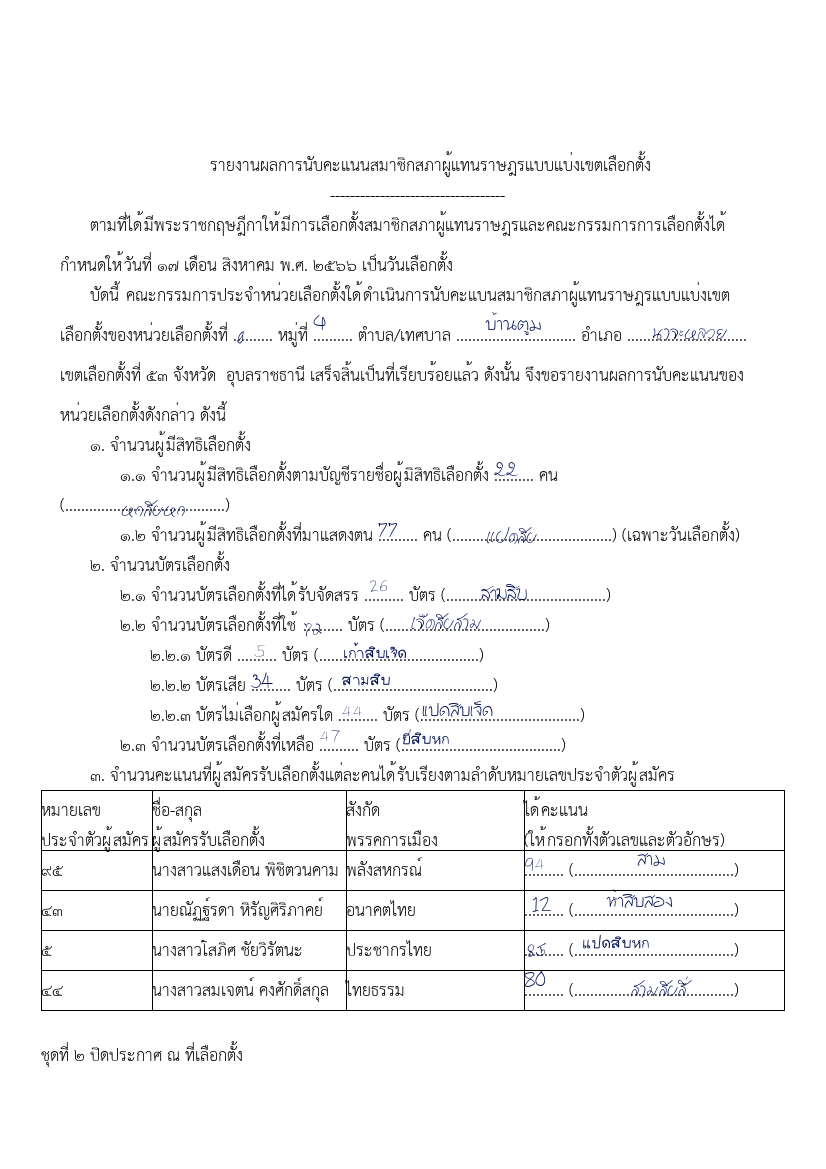

In [687]:
image = Image.new('RGB', (image_width, image_height,), '#fff')
draw = ImageDraw.Draw(image,)

pen_color = random.choice(['#000F55', '#383b3e', '#ac3235'])

start_y = 150
start_x = 60
max_x = image_width - start_x

tambon = geo_names.sample()

text_bboxes = []
temp_token = {'text': [],'bbox': BBox()}

line_hieght = 30
curr_y = start_y
curr_x = start_x

table_flag = False
table_cells = []

for token in tokens:
    ## dealing with table
    if token == '%%table' and not table_flag:
        table_flag = True
        continue
    elif token == '%%table' and table_flag:
        table_flag = False
        # filter
        table_cells = [x for x in table_cells if x and x[0]]
        font=ImageFont.truetype('formal/THSarabun.ttf',size=20)

        table_width = image_width * 0.9
        table_column_size = [0.15,0.26,0.24,0.35]
        margin = 10

        start_y = curr_y
        start_x = (image_width - table_width)/2
        line_height = 40
        curr_y  = start_y
        for row in table_cells:
            curr_x = start_x
            row_start = (curr_x, curr_y)
            row_max_y = curr_y + line_height
            for col_size, cell_tokens in zip(table_column_size, row):
                cell_width = col_size * table_width
                temp_y = curr_y
                temp_x = curr_x
                for token in cell_tokens + ['<sep>']:
                    if token in '<sep>':
                        x, y = TextToken('\n').put_on(curr_x, curr_y, temp_x, temp_x+cell_width, line_height, draw)
                        curr_y = y
                        curr_x = temp_x
                    else:
                        line = TextToken(token)
                        x, y = line.put_on(curr_x, curr_y+5, temp_x, max_x, line_height, draw)
                        curr_x = x
                
                row_max_y = max(row_max_y, curr_y)
                curr_y = temp_y
                curr_x = temp_x + cell_width
                draw.rectangle((*row_start, curr_x, row_max_y), outline='#000')
            curr_y = row_max_y
        continue
    elif table_flag:
        if token == '\n':
            table_cells.append([])
            table_cells[-1].append([])
        elif token == '|':
            table_cells[-1].append([])
        else:
            if not table_cells:
                table_cells.append([])
            if not table_cells[-1]:
                table_cells[-1].append([])
            table_cells[-1][-1].append(token)

        continue
    ##
    token = TextToken(token)
    x, y = token.put_on(curr_x, curr_y, start_x, max_x, line_height, draw)
    curr_x = x
    curr_y = y

image

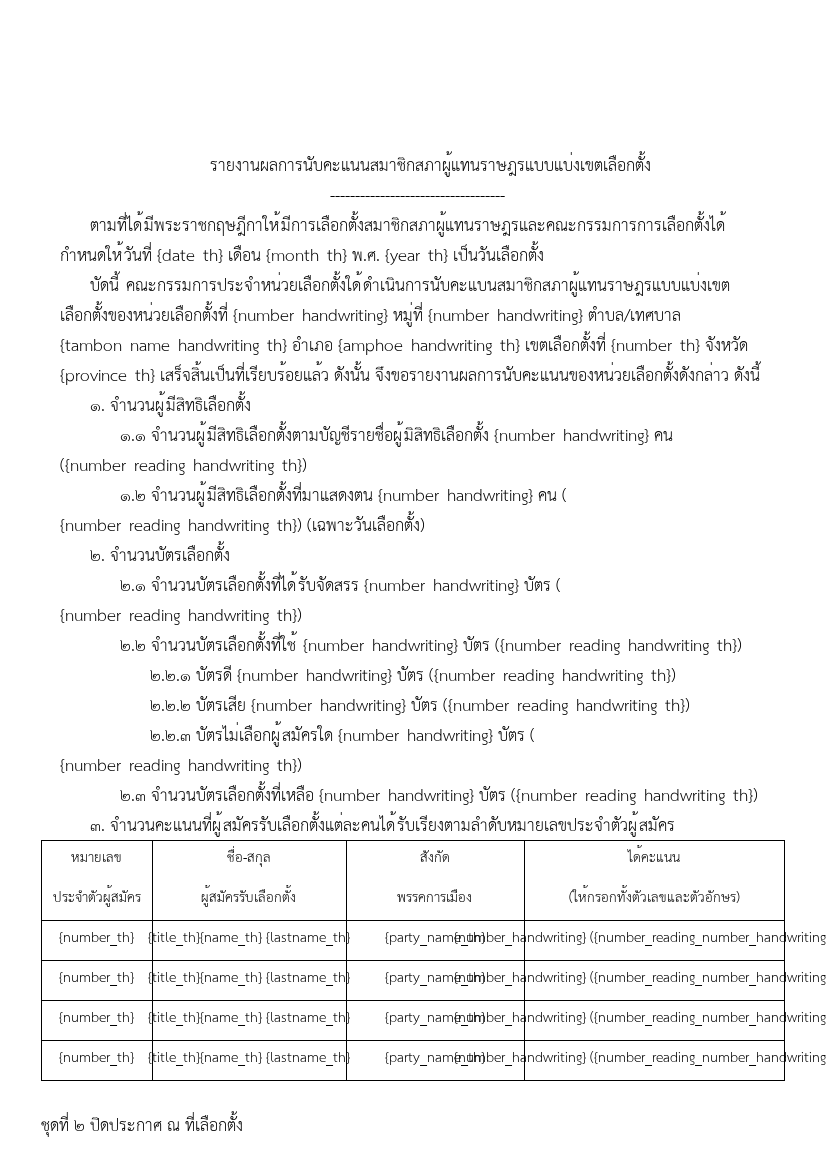

In [660]:
#create blank white paper
image = Image.new('RGB', (image_width, image_height,), '#fff')
draw = ImageDraw.Draw(image,)

pen_color = random.choice(['#000F55', '#383b3e', '#ac3235'])

start_y = 150
start_x = 60
max_x = image_width - start_x

tambon = geo_names.sample()

text_bboxes = []
temp_token = {'text': [],'bbox': BBox()}

line_hieght = 30
curr_y = start_y
curr_x = start_x

table_flag = False
table_cells = []
for token in tokens:
    font_type = 'sarabun'
    font_color = '#000'
    handwriting_text = ''

    ## dealing with table
    if token == '%%table' and not table_flag:
        table_flag = True
        continue
    elif token == '%%table' and table_flag:
        table_flag = False
        # filter
        table_cells = [x for x in table_cells if x and x[0]]
        font=ImageFont.truetype('formal/THSarabun.ttf',size=20)

        table_width = image_width * 0.9
        table_column_size = [0.15,0.26,0.24,0.35]
        margin = 10

        start_y = curr_y
        start_x = (image_width - table_width)/2
        line_height = 40
        curr_y  = start_y
        for row in table_cells:
            curr_x = start_x
            row_start = (curr_x, curr_y)
            row_max_y = curr_y + line_height
            for col_size, cell_tokens in zip(table_column_size, row):
                cell_width = col_size * table_width
                lines = ['']
                for token in cell_tokens:
                    if token == '<sep>':
                        lines.append('')
                    else:
                        lines[-1] += token
                text = ''.join(cell_tokens)

                temp_y = curr_y
                for line in lines:
                    x0,y0,x1,y1 = draw.textbbox((curr_x+5, curr_y+5), line, font=font)
                    align_center = True
                    if align_center:
                        # center
                        x0 = curr_x + cell_width / 2 - (x1-x0)/2
                    else:
                        # not center
                        x0 = curr_x+5
                    draw.text((x0, curr_y+5,), line, '#000', font=font)
                    x0,y0,x1,y1 = draw.textbbox((x0, curr_y+5,), line, font=font)
                    bbox = BBox()
                    bbox.merge(x0,y0,x1,y1)
                    text_bboxes.append({'text': line, 'bbox': bbox})
                    curr_y += line_height

                row_max_y = max(row_max_y, curr_y)

                curr_y = temp_y
                curr_x += cell_width
                draw.rectangle((*row_start, curr_x, row_max_y), outline='#000')
            curr_y = row_max_y
        continue
    elif table_flag:
        if token == '\n':
            table_cells.append([])
            table_cells[-1].append([])
        elif token == '|':
            table_cells[-1].append([])
        else:
            if not table_cells:
                table_cells.append([])
            if not table_cells[-1]:
                table_cells[-1].append([])
            table_cells[-1][-1].append(token)

        continue
    ##
    
    x0,y0,x1,y1 = draw.textbbox((curr_x,curr_y), token, font=fonts['sarabun'].get())
    
    if x1 > max_x or token == '\n':
        # start new line
        curr_x = start_x 
        curr_y += line_hieght
        text_bboxes.append(temp_token)
        temp_token = {'text': [],'bbox': BBox()}
        if token == '\n': continue
    if token == '\t':
        # tab
        text_bboxes.append(temp_token)
        temp_token = {'text': [],'bbox': BBox()}
        curr_x += 30; continue

    elif token == ' ':
        text_bboxes.append(temp_token)
        temp_token = {'text': [],'bbox': BBox()}
        curr_x += fonts['sarabun'].get().getlength(' ')
        
        continue
    
    x0,y0,x1,y1 = draw.textbbox((curr_x,curr_y), token, font=fonts['sarabun'].get())
    if font_type == 'handwriting':
        font=fonts['handwriting'].get()
        text_bboxes.append(temp_token)
        temp_token = {'text': [],'bbox': BBox()}
        # draw ............... for forms placeholder
        draw.text((curr_x, curr_y), token, font_color, font=fonts['sarabun'].get())
        # get the text width
        text_width = font.getlength(handwriting_text)
        # calculate position for putting text
        xy_pos = (random.randint(x0,max(x0, int(x1-text_width-10))), random.randint(curr_y-10, curr_y+2))
        draw.text(xy_pos,handwriting_text, pen_color, font=font)
        xyxy = draw.textbbox(xy_pos, handwriting_text, font=font)
        temp_token['text'].append(handwriting_text)
        temp_token['bbox'].merge(*xyxy)
        text_bboxes.append(temp_token)
        temp_token = {'text': [],'bbox': BBox()}
    else:
        draw.text((curr_x, curr_y), token, font_color, font=fonts['sarabun'].get())
        temp_token['text'].append(token)
        temp_token['bbox'].merge(x0,y0,x1,y1)

    curr_x = x1

# for xyxy in text_bboxes: draw.rectangle(xyxy, outline='red')
image

In [322]:
bboxes_on_image = []
for x in text_bboxes:
    if x['text']:
        bboxes_on_image.append(BoundingBox(*x['bbox'].to_list()))

In [640]:
seq = iaa.Sequential([
    iaa.Crop(px=(0, 10)),
    iaa.ElasticTransformation(alpha=200, sigma=40),
    iaa.pillike.EnhanceBrightness(factor=(0.6,1.4)),
    iaa.CoarseDropout(0.0005, size_percent=0.4),
    iaa.AllChannelsCLAHE(clip_limit=(1, 10)),
    iaa.pillike.FilterSharpen(),
    iaa.BlendAlphaMask(
        iaa.InvertMaskGen(0.5, iaa.VerticalLinearGradientMaskGen()),
        iaa.GaussianBlur(sigma=(1, 2.2)),
    ),
    iaa.Affine(rotate=(-2, 2)),
    iaa.ElasticTransformation(alpha=200, sigma=60),
])

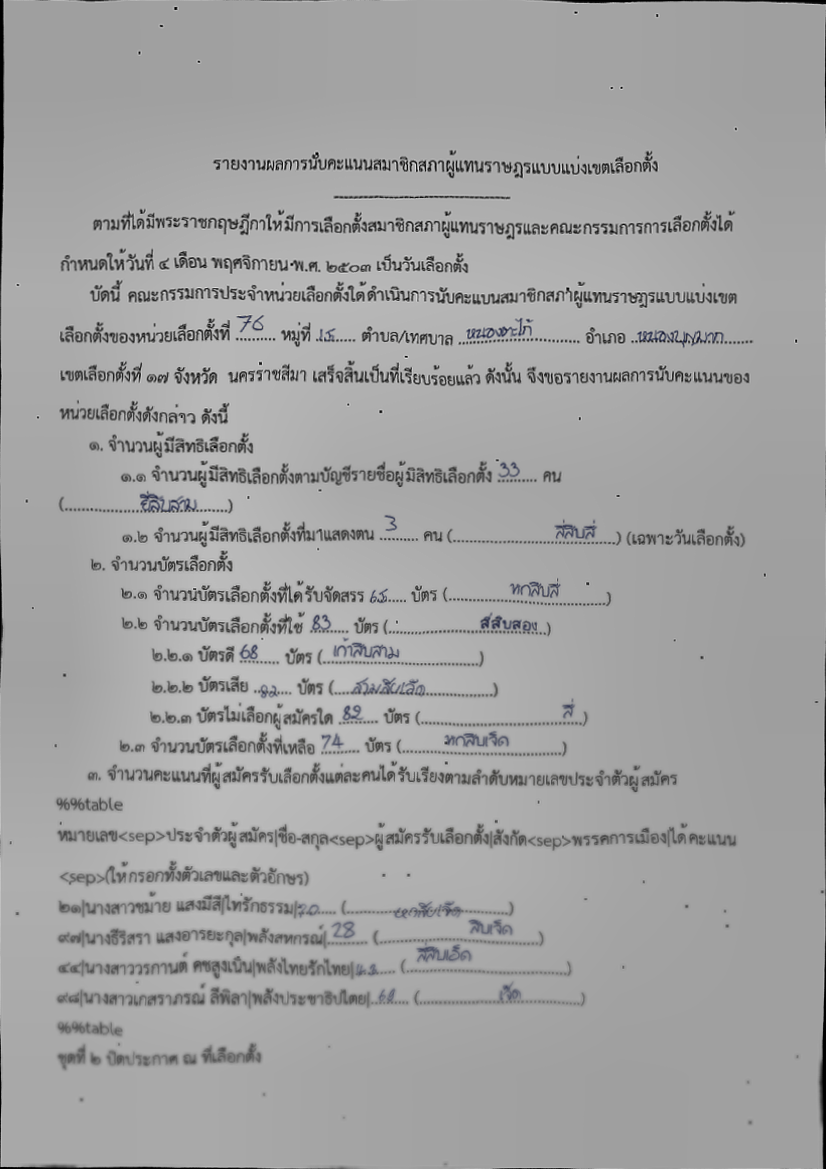

In [642]:
np_image = np.array(image)
aug_images,aug_bboxes=seq(
    images=[np_image],
    bounding_boxes=[BoundingBoxesOnImage([], shape=np_image.shape)]
)
Image.fromarray(aug_bboxes[0].draw_on_image(aug_images[0], size=1, color=[0, 0, 255]))